# OCO2_GEOS_L3_v10r 年尺度LAT-Anomaly生成

In [1]:
import numpy as np
import netCDF4 as nc
import os
from scipy.interpolate import interp1d
from maplot import map_plot_surface_sub, map_plot_surface

inPath = "H:\\XCO2\\OCO2_GEOS_L3_v10r\\src_daily_resample\\"
outPath = "H:\\XCO2\\OCO2_GEOS_L3_v10r\\LAT_year\\"

china = np.load("china_area.npy") > 0.0
globe = np.load("globe.npy")

filenames = os.listdir(inPath)

In [2]:
def read(name):
    d = nc.Dataset(inPath+name, 'r').variables["XCO2"][:].data[0] * 1e6
    # d[~globe] = np.NaN
    d[~china] = np.NaN
    return d

for year in range(2015, 2022):
    year_filenames = [filename for filename in filenames if filename[20:24]==f"{year}"]
    data = np.array([read(f) for f in year_filenames])  # shape: (~365, 180, 360)
    
    # 计算纬度带背景值
    medians = np.nanmedian(data.reshape(data.shape[0], 18, 10, 360), axis=(2, 3))  # 每日文件都获得18个纬度带的中值，shape: (n, 18)
    medians_lat = np.linspace(-85, 85, 18)  # shape: (18,)
    f = interp1d(medians_lat, medians)
    to_interp = np.linspace(-84.5, 84.5, 170)  # 顶部和底部各5个纬度无法插值
    nan_rows = np.full((data.shape[0], 5), np.nan)  # 填充矩阵
    bck = np.broadcast_to(np.concatenate((nan_rows, f(to_interp), nan_rows), axis=1)[:, :, np.newaxis],
                          (data.shape[0], 180, 360))  # shape: (n, 180, 360)，插值、填充后广播到经度上
    ano = np.nanmean(data - bck, axis=0)  # 合成一年
    np.save(outPath+f"MappingXCO2_{year}", ano)
    print(f"{year} completed.")

F:\anaconda3\envs\GIS\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\alzio\AppData\Local\Temp\ipykernel_29928\3950619323.py:19: RuntimeWarning: Mean of empty slice
  ano = np.nanmean(data - bck, axis=0)  # 合成一年


2015 completed.
2016 completed.
2017 completed.
2018 completed.
2019 completed.
2020 completed.
2021 completed.


H:\preprocessing_code\XCO2\OCO-2\OCO2_GEOS_L3_v10r\maplot.py:92: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  mapPlot = Map.pcolor(x, y, m, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
H:\preprocessing_code\XCO2\OCO-2\OCO2_GEOS_L3_v10r\maplot.py:92: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  mapPlot = Map.pcolor(x, y, m, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
H:\preprocessing_code\XCO2\OCO-2\OCO2_GEOS_L3_v10r\maplot.py:92: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated

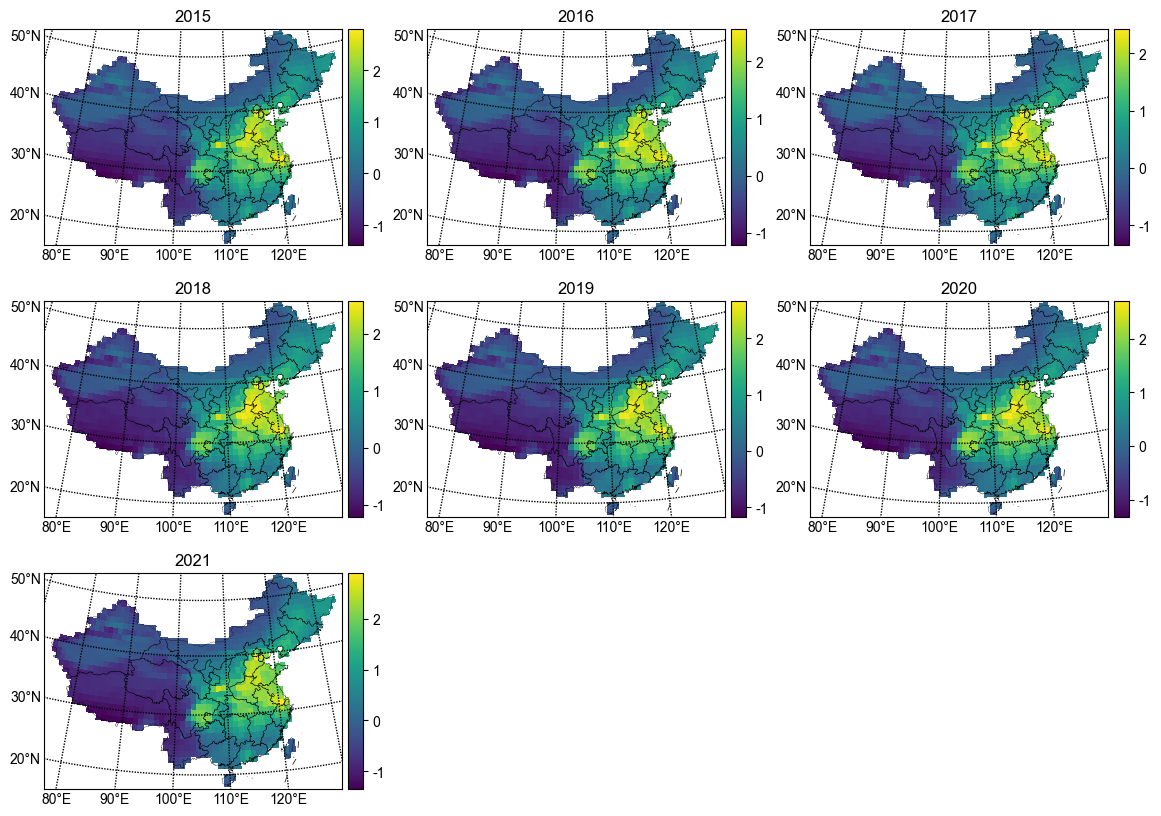

In [3]:
# 绘制测试
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sub = 331
for year in range(2015, 2022):
    plt.subplot(sub)
    temp = np.load(outPath + f"MappingXCO2_{year}.npy")
    temp[~china] = np.NaN
    map_plot_surface_sub(temp, "viridis", None, None, f"{year}")
    sub += 1

# plt.savefig(outPath + "XCO2_anomaly.jpg", dpi=600, bbox_inches='tight')
plt.show()